# **Method 3 : $n$ pevious states to $n$ forward states approach**

 > **Model hypothesis:**
* Autonomous RNN with a 3 hidden layers MLP.
* Inputs = [ Chl ; Phy ] $(t - 1)$
* Ouputs = [ [ Chl ; Phy ] $(t)$ ;  [ Chl ; Phy ] $(t + 1)$ ; ... ; [ Chl ; Phy ] $(t + 5)$ ]

> **Working principle :**

> The neural network takes as input the $n$ previous states, and returns the $n$ followings.  
> Here, we tested the approach for $n$ ∈ {1 ; 2 ; 3 ; 4 ; 5 ; 6}

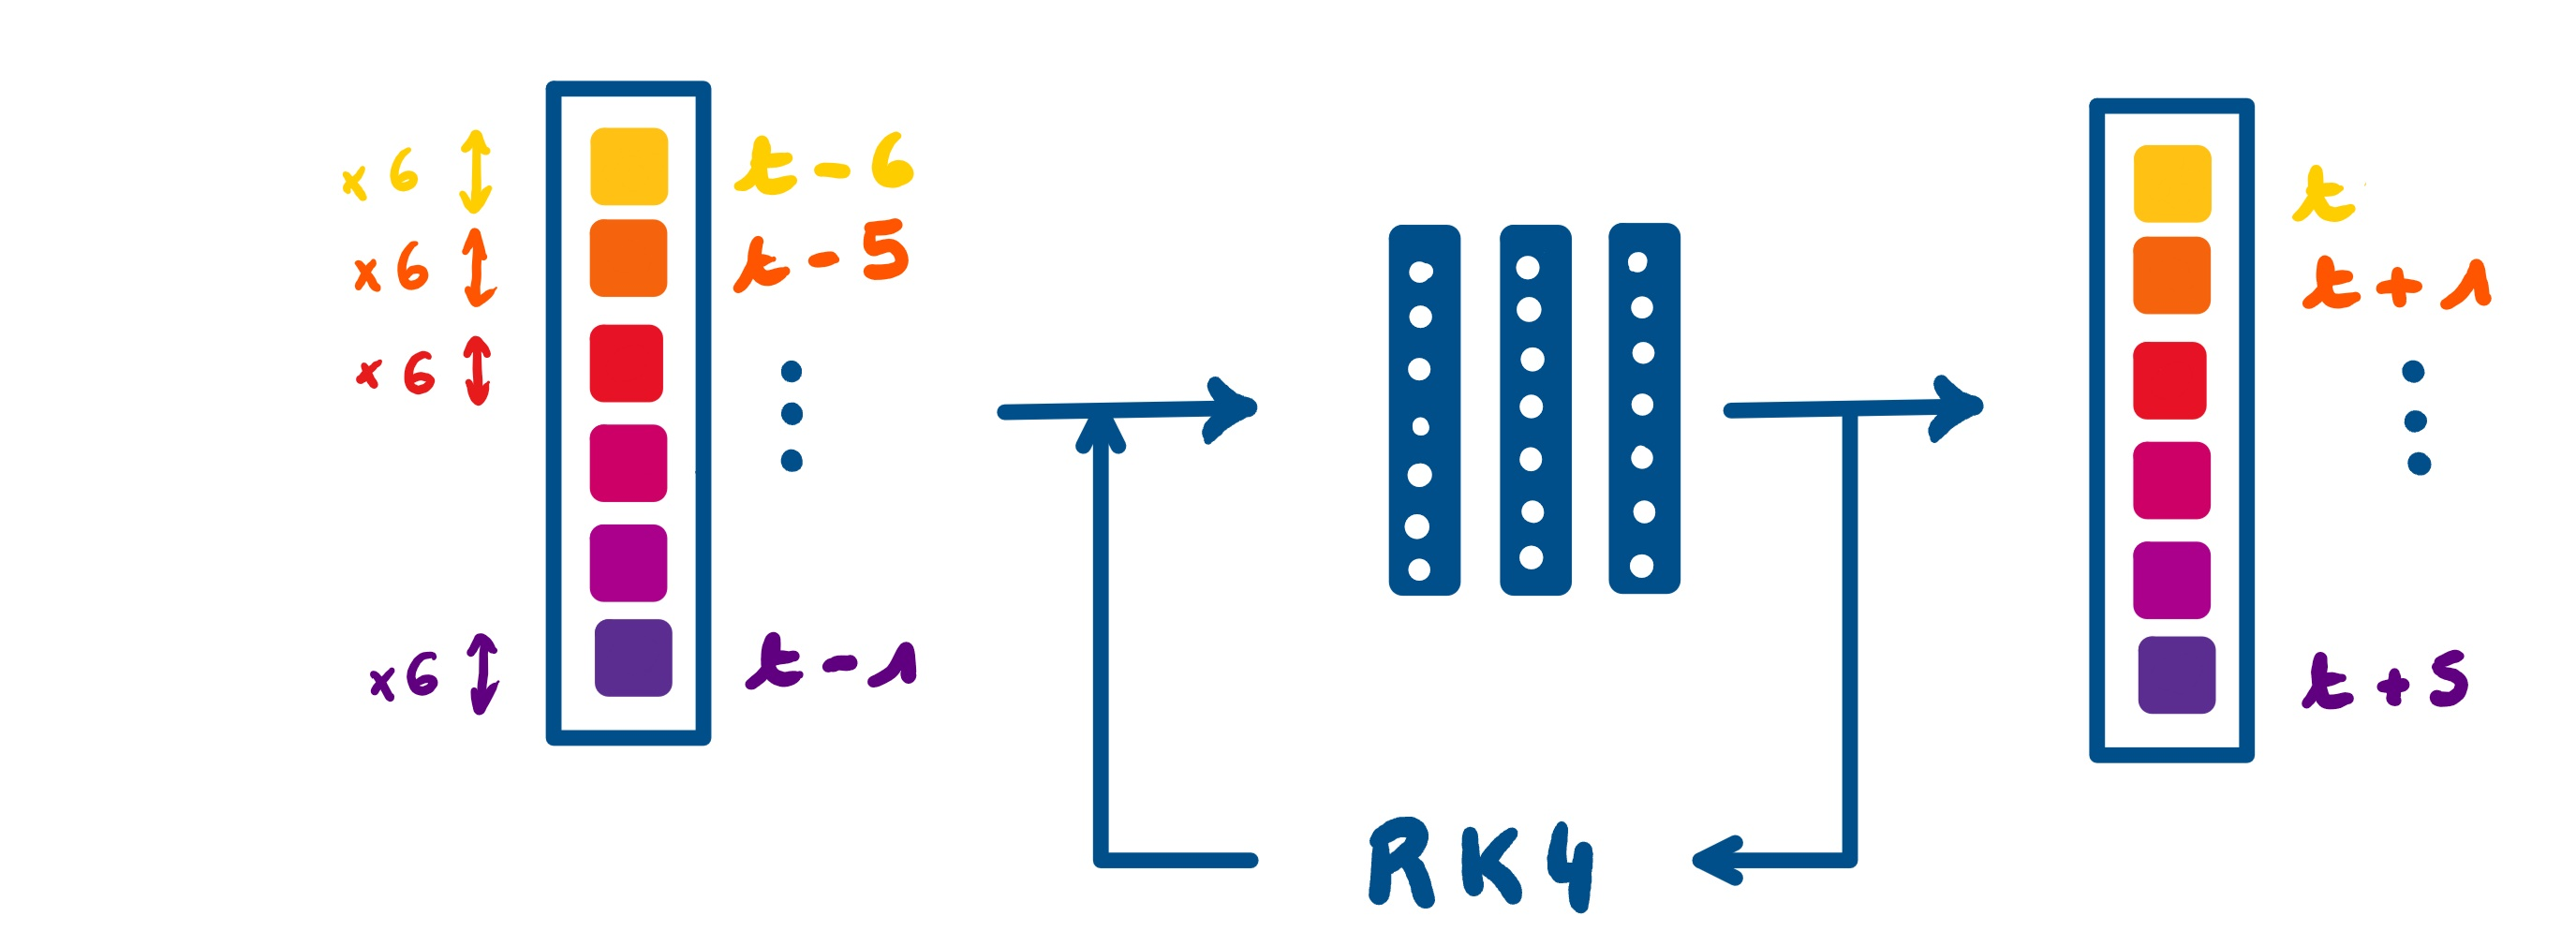

> ## **Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


> ## **Load the formated data**

In [3]:
directory = '/content/drive/My Drive/Colab Notebooks/North_Sea/'
exec(open(directory + 'src/inputs_method3.py').read())

P1    = [1960;1980]      <=> Indices = [0;234]
P2    = [1981;2010]      <=> Indices = [246;587]
SHIFT = [1981;1989] ⊂ P2 <=> Indices = [246;342]

Input vector shape : (588, 6)

Input  train vector of shape : torch.Size([227, 24])  and variance : 0.9826027117699769
Target train vector of shape : torch.Size([227, 24])

Input  test  vector of shape : torch.Size([334, 24])  and variance : 1.6007591042300544
Target test  vector of shape : torch.Size([334, 24])


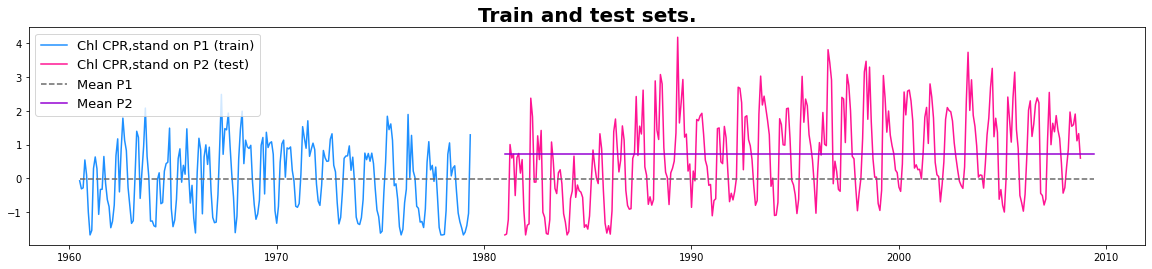

In [4]:
params = {}
params['dt_horizon'] = 4

time_years, inp_train, inp_true_train, time_years_train, var_train, inp_test, inp_true_test, time_years_test, var_test = inputs_3(directory, params['dt_horizon'])

> ## **Model settings**

In [5]:
params['dim_chloro'] = 1
params['dim_phy'] = 5
params['dim_input_vect'] = params['dim_chloro'] + params['dim_phy']
params['dim_input'] = params['dim_input_vect'] * params['dt_horizon'] 
params['dim_hidden_1'] = 200
params['dim_hidden_2'] = 150
params['dim_hidden_3'] = 100
params['dim_output'] = params['dim_input']
params['batchsize'] = 50
params['epoch'] = 400
params['nb_batch'] = len(time_years)//params['batchsize'] + 1 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
idx1980 = np.where(np.round(time_years,1) == 1980)[0][0]

In [6]:
exec(open(directory + 'src/RNN.py').read())
model_RNN = INT_net(params)

In [7]:
training_dataset = torch.utils.data.TensorDataset(inp_train, inp_true_train)
test_dataset = torch.utils.data.TensorDataset(inp_test, inp_true_test)

dataloaders = {'train': torch.utils.data.DataLoader(training_dataset, batch_size = params['batchsize'], shuffle=False, num_workers=2, pin_memory=True), 'test': torch.utils.data.DataLoader(test_dataset, batch_size = params['batchsize'], shuffle=False, num_workers=2, pin_memory=True)}

num_epochs = params['epoch']
optimizer = optim.Adam(model_RNN.parameters(), lr = 1e-4)

> ## **Training**

... Var of train set = 0.983
... Var of test  set = 1.601

Epoch [1 / 400] : Training data -- loss 14.757 ; Testing data -- loss 15.553
Epoch [11 / 400] : Training data -- loss 11.857 ; Testing data -- loss 12.664
Epoch [21 / 400] : Training data -- loss 8.411 ; Testing data -- loss 9.585
Epoch [31 / 400] : Training data -- loss 7.230 ; Testing data -- loss 8.705
Epoch [41 / 400] : Training data -- loss 6.408 ; Testing data -- loss 7.983
Epoch [51 / 400] : Training data -- loss 6.150 ; Testing data -- loss 7.685
Epoch [61 / 400] : Training data -- loss 5.942 ; Testing data -- loss 7.455
Epoch [71 / 400] : Training data -- loss 5.755 ; Testing data -- loss 7.267
Epoch [81 / 400] : Training data -- loss 5.588 ; Testing data -- loss 7.104
Epoch [91 / 400] : Training data -- loss 5.439 ; Testing data -- loss 6.975
Epoch [101 / 400] : Training data -- loss 5.303 ; Testing data -- loss 6.858
Epoch [111 / 400] : Training data -- loss 5.195 ; Testing data -- loss 6.760
Epoch [121 / 400] : Trai

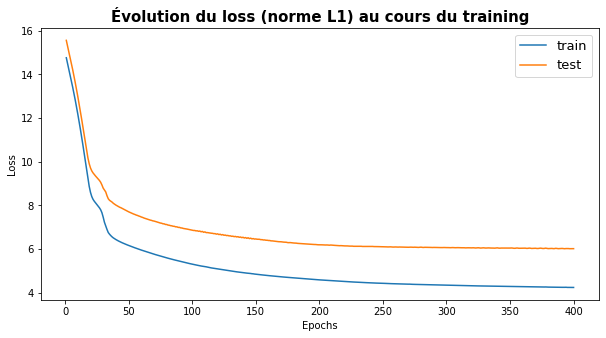

In [8]:
x_epoch = np.arange(1, num_epochs+1, 1)

NL1_train = np.zeros(num_epochs)
NL1_test  = np.zeros(num_epochs)

print('... Var of train set = %.3f' %var_train)
print('... Var of test  set = %.3f' %var_test)
print()

model_RNN.float()
for epoch in range(num_epochs):
    for phase in ['train', 'test']:
        if phase == 'train' :
          model_RNN.train()
        else:
          model_RNN.eval() 

        loss_all = 0.
        num_all = 0
        
        for i, data in enumerate(dataloaders[phase]):
            model_RNN.zero_grad()
            optimizer.zero_grad()
            
            inp = data[0].to(device)
            true = data[1].to(device)
            batch_size = inp.shape[0]
            dt = torch.ones([batch_size, 1])

            pred = model_RNN(inp, dt)
    
            loss = torch.sum(abs(pred - true))
            
            if phase == 'train' :
                loss.backward()
                optimizer.step()
            
            loss_all = loss_all + loss.cpu().detach().numpy() * inp.shape[0]
                
            num_all  += batch_size

        if phase == 'train' :
            NL1_train[epoch] = loss_all / (num_all * inp.shape[1] * params['dt_horizon'])

        else :
            NL1_test[epoch] = loss_all / (num_all * inp.shape[1]  * params['dt_horizon'])
    
    if epoch%10 == 0:
        print("Epoch [%d / %d] : Training data -- loss %.3f ; Testing data -- loss %.3f"%(epoch+1, num_epochs, NL1_train[epoch], NL1_test[epoch]))

plt.figure(figsize = (10,5))
plt.plot(x_epoch, NL1_train, label = 'train')
plt.plot(x_epoch, NL1_test, label = 'test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Évolution du loss (norme L1) au cours du training", size = 15, fontweight = 'bold')
plt.legend(prop = {'size' : 13})

>> ## **Model Chl reconstruction**

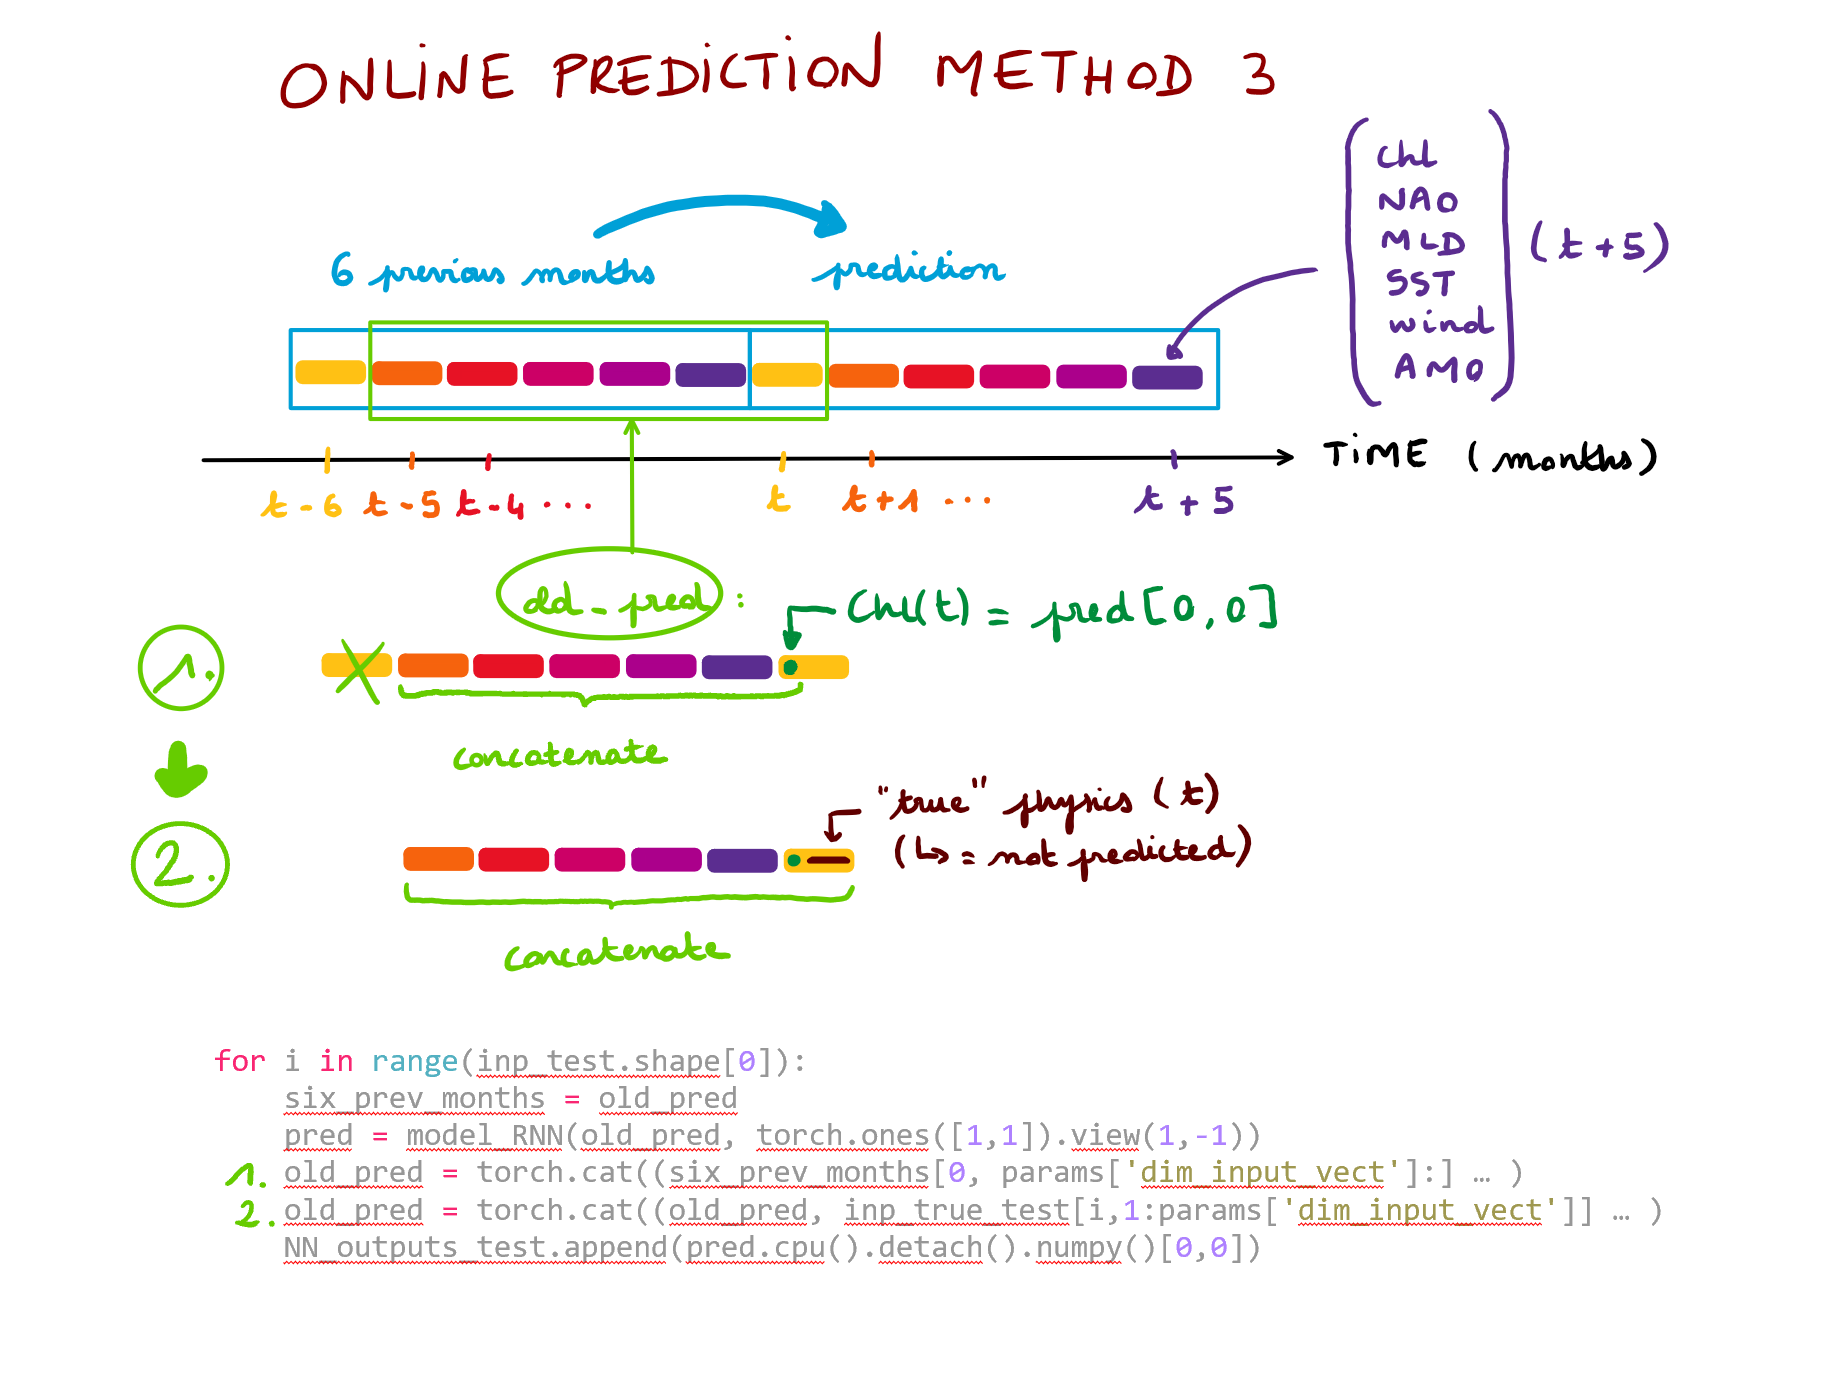

In [9]:
exec(open(directory + 'src/plots.py').read())

NN_outputs_test = []
Chl_stand_test  = inp_true_test[:,0].cpu().detach().numpy().reshape(1,-1)[0]
old_pred = inp_test[0].view(1,-1)
for i in range(inp_test.shape[0]):
    six_prev_months = old_pred
    pred = model_RNN(old_pred, torch.ones([1,1]).view(1,-1))
    old_pred = torch.cat((six_prev_months[0, params['dim_input_vect']:].view(1,-1), pred[0,0].view(1,-1)), axis = 1) # drop the oldest month (t-6) of lenght params['dim_input_vect'] = 6, and concat with Chl predicted at month t
    old_pred = torch.cat((old_pred, inp_true_test[i,1:params['dim_input_vect']].view(1,-1)), axis = 1) # concat with the true physics à month t
    NN_outputs_test.append(pred.cpu().detach().numpy()[0,0])

MSE_test = np.mean((Chl_stand_test - NN_outputs_test)**2/var_test)


NN_outputs_train = []
Chl_stand_train = inp_true_train[:,0].cpu().detach().numpy().reshape(1,-1)[0]
old_pred = inp_train[0].view(1,-1)
for i in range(inp_train.shape[0]):
    six_prev_months = old_pred
    pred = model_RNN(old_pred, torch.ones([1,1]).view(1,-1))
    old_pred = torch.cat((six_prev_months[0, params['dim_input_vect']:].view(1,-1), pred[0,0].view(1,-1)), axis = 1) # drop the oldest month (t-6) of lenght params['dim_input_vect'] = 6, and concat with Chl predicted at month t
    old_pred = torch.cat((old_pred, inp_true_train[i,1:params['dim_input_vect']].view(1,-1)), axis = 1) # concat with the true physics à month t
    NN_outputs_train.append(pred.cpu().detach().numpy()[0,0])

MSE_train = np.mean((Chl_stand_train - NN_outputs_train)**2/var_train)

>> ### **Reconstruction on P1+P2** 

In [10]:
### CHANGE YOUR GRAPHIC PREFERENCES (LINECOLOR, LINESTYLE, FONTSIZE, LABELS...) THE WAY YOU WANT
## CHL MLP TEST GRAPHIC STYLE
pred_test_style = {}

pred_test_style['color'] = 'crimson'
pred_test_style['label'] = None
pred_test_style['linewidth'] = 1.5
pred_test_style['linestyle'] = 'solid'
pred_test_style['marker'] = None

pred_test_style['mean_color'] = 'crimson'
pred_test_style['mean_label'] = None
pred_test_style['mean_linewidth'] = 1.5
pred_test_style['mean_linestyle'] = 'solid'

## CHL MLP TRAIN GRAPHIC STYLE
pred_train_style = {}

pred_train_style['color'] = 'crimson'
pred_train_style['label'] = 'Chl MLP, P1 (train) : ' + str(round(MSE_train,4)) + '\n' + 'Chl MLP, P2 (test) : ' + str(round(MSE_test, 4))
pred_train_style['linewidth'] = 1.5
pred_train_style['linestyle'] = 'solid'
pred_train_style['marker'] = None

pred_train_style['mean_color'] = 'crimson'
pred_train_style['mean_label'] = None
pred_train_style['mean_linewidth'] = 1.5
pred_train_style['mean_linestyle'] = 'solid'

## CHL CPR GRAPHIC STYLE
Chl_style = {}

Chl_style['color'] = 'royalblue'
Chl_style['label'] = 'Chl CPR'
Chl_style['linewidth'] = 1.5
Chl_style['linestyle'] = 'solid'
Chl_style['marker'] = None

Chl_style['mean_all_color'] = 'dimgrey'
Chl_style['mean_all_label'] = None
Chl_style['mean_all_linewidth'] = 1.5
Chl_style['mean_all_linestyle'] = 'dashed'

Chl_style['mean_test_color'] = 'royalblue'
Chl_style['mean_test_label'] = None
Chl_style['mean_test_linewidth'] = 1.5
Chl_style['mean_test_linestyle'] = 'solid'

Chl_style['mean_train_color'] = 'royalblue'
Chl_style['mean_train_label'] = None
Chl_style['mean_train_linewidth'] = 1.5
Chl_style['mean_train_linestyle'] ='solid'

graph_settings = {}
graph_settings['figsize'] = (20,4)
graph_settings['xlabel'] = 'time (years)'
graph_settings['ylabel'] = 'Chl anomalies'
graph_settings['title'] = 'Chl CPR anomalies and Chl MLP anomalies on P1 ([1960;1980]) and P2 ([1981;2010]).'
graph_settings['title_size'] = 20
graph_settings['legend_size'] = 13

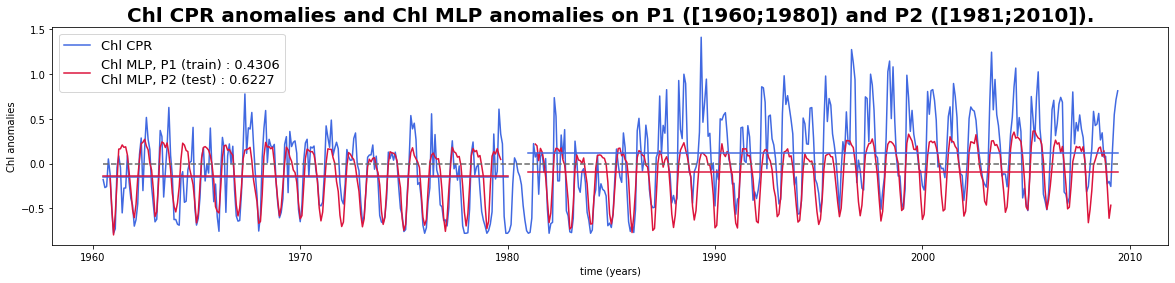

In [11]:
time_serie_all(directory, NN_outputs_test, NN_outputs_train, Chl_stand_test, Chl_stand_train, pred_test_style, pred_train_style, Chl_style, graph_settings, model=3)

> ### **Reconstruction on P2**

In [12]:
## ADD/CHANGE USEFUL KEYS FOR P2 MLP RECONSTRUCTION
Chl_style['test_label'] = 'Chl CPR P2'
Chl_style['mean_test_color'] = 'blue'
Chl_style['mean_test_label'] = 'Mean Chl CPR P2'
Chl_style['mean_test_linestyle'] = 'dashed'
Chl_style['train_label'] = 'Chl CPR P1'
Chl_style['mean_train_color'] = 'black'
Chl_style['mean_train_label'] = 'Mean Chl CPR P1'
Chl_style['mean_train_linestyle'] = 'dashed'

graph_settings['title'] = "Chl CPR anomalie and Chl MLP anomalies on P2([1981;2010])."

pred_test_style['label'] = 'Chl MLP P2 (test):%.4f'%MSE_test
pred_test_style['mean_color'] = 'red'
pred_test_style['mean_label'] = 'Mean Chl MLP P2'
pred_test_style['mean_linestyle'] = 'dashed'

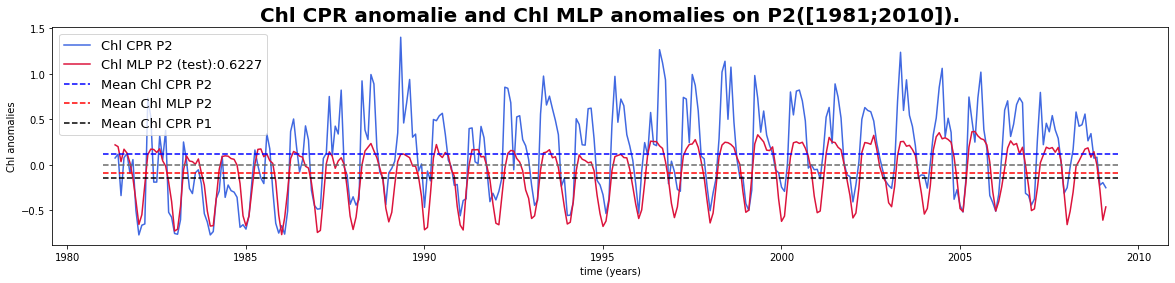

In [13]:
time_serie_test(directory, NN_outputs_test, Chl_stand_test, Chl_stand_train, pred_test_style, Chl_style, graph_settings, model=3)

>> ### **Annual means and cumulated sums**

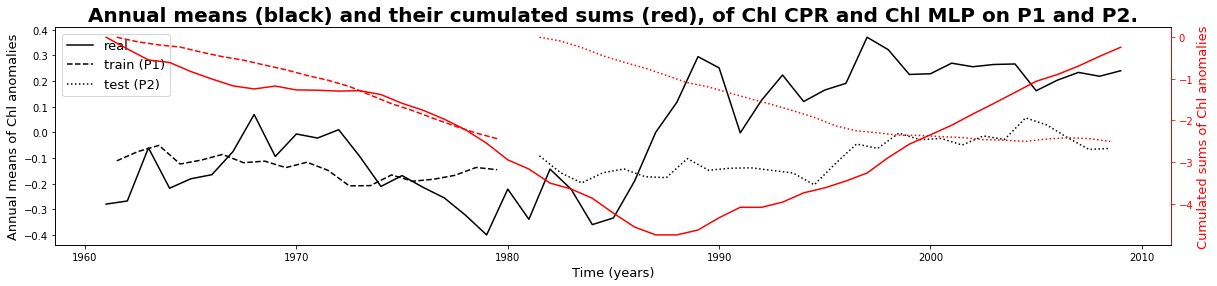

In [14]:
annualMeans(directory, NN_outputs_test, NN_outputs_train, Chl_stand_test, Chl_stand_train)

>> ### **Scatter plots**

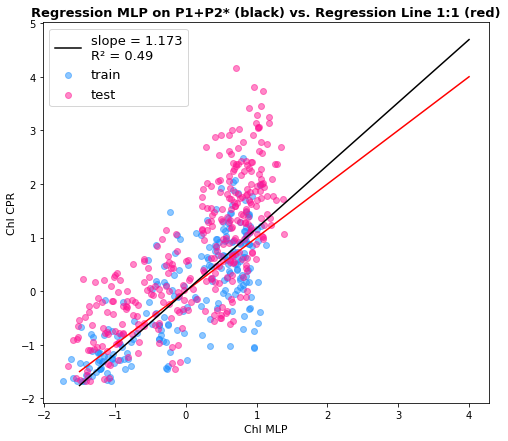

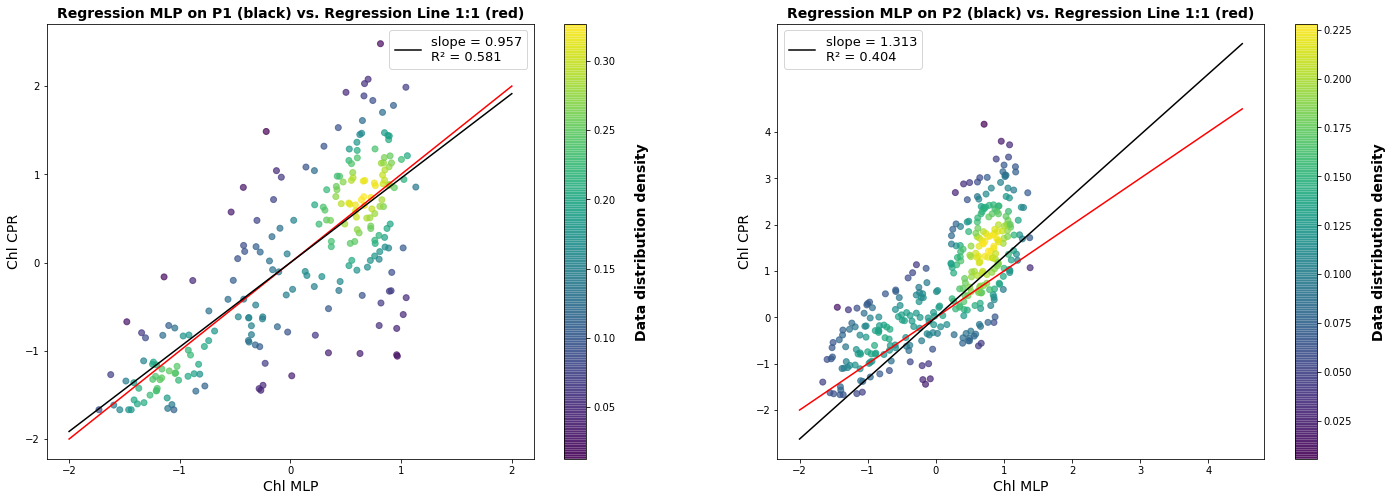

In [15]:
scatterplots(NN_outputs_test, NN_outputs_train, Chl_stand_test, Chl_stand_train)

> ## **Model saving**

In [16]:
## SAVE THE MODEL WEIGHTS IN THE 'MODELS' FILE
torch.save(model_RNN.state_dict(), directory + 'models/model_3_weights.pth')